# Capstone 1 Project - Black Friday Prediction

### Description
The dataset is a sample of the transactions on a Black Friday from a retail store. The store is interested in predicting customer purchases for different products. In this, they are particularly interested in predicting the amount of purchase based on previous purchase patterns. 

There can also be some classification done on some variables. Like predicting the sex of the customer, age of the customer etc. Some amount of clustering can also be done with this dataset.

##### Acknowledgements
The dataset comes from a competition hosted by Analytics Vidhya.

In [676]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style #style.available
import matplotlib
%matplotlib inline
#print(style.available)
#sns.set_style("whitegrid")
#sns.set_context("ggplot")
#[f.name for f in matplotlib.font_manager.fontManager.afmlist] -- Find fonts on the machine

style.use('seaborn-notebook') #sets the size of the charts
style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "serif"


In [677]:
#Load the data
data = pd.read_csv('data\BlackFriday.csv')

In [678]:
# Lets see if the data types and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


### Step 1 - Data Clean up / Data Wrangling

In [679]:
#Lets check if there are 0 values in Product_Category_2 and Product_Category_3 so that we can replace NaN with 0
data[(data['Product_Category_2'] ==0) | (data['Product_Category_3'] ==0)] 


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase


In [680]:
# Lets get rid of NaN values and replace them with 0. 
data.fillna(value=0, inplace=True)

# Check if all NaN values are covered
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            537577 non-null float64
Product_Category_3            537577 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


In [681]:
# Notice that the product catergories 2 and 3 are floats, where as 1 is an int. Lets make it consistent. Also rename the columns.
data['ProdCat1'] = data.Product_Category_1
data['ProdCat2'] = data.Product_Category_2.astype(int)
data['ProdCat3'] = data.Product_Category_3.astype(int)

In [682]:
# Check which columns are not needed and drop them

# See if User_ID represents an individual person
print(data.User_ID.unique().shape)
print(data.groupby(['User_ID','Gender']).count().shape)

# The number of rows match up. This means it is tied to an unique individual

(5891,)
(5891, 13)


In [683]:
# Now check Product_ID as we know that User_ID is a unique person
print(data.groupby(['User_ID','Product_ID']).count().shape)
print(data.shape)

# Notice that they are equal. Meaning userid-productid could be a unique key

(537577, 13)
(537577, 15)


In [684]:
# Lets check if there is any relation between Product_ID and the 3 product categories
print('Unique Product_IDs : {}'.format(data.Product_ID.unique().shape[0]))
print('Unique product category combos (no unique ordering) : {}'.format(data.groupby(['ProdCat3','ProdCat2','ProdCat1']).count().shape[0]))
print('Unique product category combos and Product_ID : {}'.format(data.groupby(['Product_ID','ProdCat1','ProdCat2','ProdCat3'])['ProdCat1','ProdCat2','ProdCat3'].count().shape[0]))

# Conclusion: There could be multiple product-ids for a combo.

Unique Product_IDs : 3623
Unique product category combos (no unique ordering) : 235
Unique product category combos and Product_ID : 3623


In [685]:
# Lets check if the ordering of the product categories has any bearing
# Create a new column that has the order of the Product Category
data['ProdCombo'] = data['ProdCat1'].astype(str)+ '-'+data['ProdCat2'].astype(str)+ '-'+data['ProdCat3'].astype(str)

# Check uniqueness of this column
print('Unique product combos: {}'.format(data.groupby(['ProdCombo']).count().shape[0]))
# Check the relationship of this column and Product_ID
print('Unique product combos: {}'.format(data.groupby(['ProdCombo','Product_ID']).count().shape[0]))

# The case for multiple product-ids for a combo is getting stronger

Unique product combos: 235
Unique product combos: 3623


In [686]:
# Lets explore some records
dff = data[data.ProdCombo=='8-9-0']
print(dff.groupby(['User_ID','ProdCombo']).count().shape)
data[(data.User_ID==1001015) & (data.ProdCombo=='8-9-0')]


(151, 14)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,ProdCat1,ProdCat2,ProdCat3,ProdCombo
6243,1001015,P00226142,M,36-45,3,A,4+,1,8,9.0,0.0,3960,8,9,0,8-9-0
396201,1001015,P00190642,M,36-45,3,A,4+,1,8,9.0,0.0,6009,8,9,0,8-9-0
435036,1001015,P00367442,M,36-45,3,A,4+,1,8,9.0,0.0,4176,8,9,0,8-9-0


##### Comment: 
Here, you can clearly see that for same user and same ProdCombo, there are 3 different Product_IDs. 
It can be concluded that this Product_ID is not relevant and can be dropped along with some other repetative columns.

In [687]:
# Drop these unneeded columns
data=data.drop(['Product_ID','Product_Category_1','Product_Category_2','Product_Category_3'], axis=1)

In [688]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Purchase                      537577 non-null int64
ProdCat1                      537577 non-null int64
ProdCat2                      537577 non-null int32
ProdCat3                      537577 non-null int32
ProdCombo                     537577 non-null object
dtypes: int32(2), int64(5), object(5)
memory usage: 45.1+ MB


In [689]:
# Lets do some EDA using feature and target variables
X = data.drop('Purchase', axis=1)
X.head()
y = data['Purchase']

In [690]:
#_ = pd.scatter_matrix(X, figsize=[12,12])

In [691]:
data.head()

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,ProdCat1,ProdCat2,ProdCat3,ProdCombo
0,1000001,F,0-17,10,A,2,0,8370,3,0,0,3-0-0
1,1000001,F,0-17,10,A,2,0,15200,1,6,14,1-6-14
2,1000001,F,0-17,10,A,2,0,1422,12,0,0,12-0-0
3,1000001,F,0-17,10,A,2,0,1057,12,14,0,12-14-0
4,1000002,M,55+,16,C,4+,0,7969,8,0,0,8-0-0


### Step 2 - Data Story by visualization

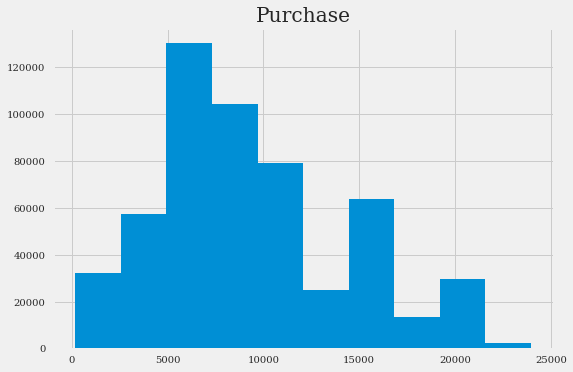

In [692]:
# Lets see how data is spread out before doing any preprocessing.
import matplotlib.style as style #style.available
#print(style.available)
#sns.set_style("whitegrid")
#sns.set_context("ggplot")

style.use('seaborn-notebook') #sets the size of the charts
style.use('fivethirtyeight')

_ = data.hist('Purchase', bins=10)
#plt.show()

# Most of the purchases are between 3000 and 12000 and around 16000 mark

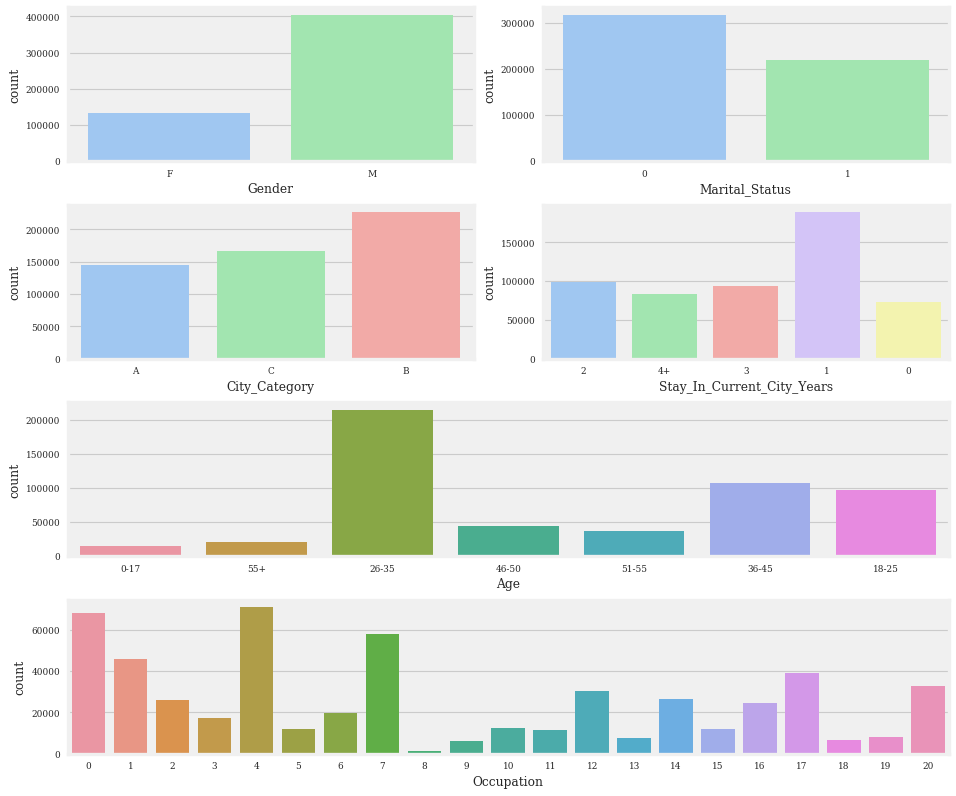

In [693]:
# Plot various histograms to see which one is a stronger variable

matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
#style.use('seaborn-paper') #sets the size of the charts
style.use('seaborn-notebook') #sets the size of the charts
style.use('seaborn-pastel') #set the style of the chart

fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot2grid((4,2),(0,0))
ax1 = sns.countplot(data.Gender)
for label in ax1.xaxis.get_ticklabels():
    label.set_fontsize(8)
for label in ax1.yaxis.get_ticklabels():
    label.set_fontsize(8)

ax2 = plt.subplot2grid((4,2),(0,1))
ax2 = sns.countplot(data.Marital_Status)
for label in ax2.xaxis.get_ticklabels():
    label.set_fontsize(8)
for label in ax2.yaxis.get_ticklabels():
    label.set_fontsize(8)

ax3 = plt.subplot2grid((4,2),(1,0))
ax3 = sns.countplot(data.City_Category)
for label in ax3.xaxis.get_ticklabels():
    label.set_fontsize(8)
for label in ax3.yaxis.get_ticklabels():
    label.set_fontsize(8)

ax4 = plt.subplot2grid((4,2),(1,1))
ax4 = sns.countplot(data.Stay_In_Current_City_Years)
for label in ax4.xaxis.get_ticklabels():
    label.set_fontsize(8)
for label in ax4.yaxis.get_ticklabels():
    label.set_fontsize(8) 

ax5 = plt.subplot2grid((4,2),(2,0), colspan=2)
ax5 = sns.countplot(data.Age)
for label in ax5.xaxis.get_ticklabels():
    label.set_fontsize(8)
for label in ax5.yaxis.get_ticklabels():
    label.set_fontsize(8) 

ax6 = plt.subplot2grid((4,2),(3,0), colspan=2)
ax6 = sns.countplot(data.Occupation)
for label in ax6.xaxis.get_ticklabels():
    label.set_fontsize(8)
for label in ax6.yaxis.get_ticklabels():
    label.set_fontsize(8) 
    
plt.tight_layout()

##### 2.1 Comments:
The above bar charts are purely counts of data elements from the set of ~537.5k rows and simply give and estimate about the number of observations in the set. They do not weigh towards the purchase amount and that analysis will be done next. This is what we can observe from the above charts:

1. Men shopped 3 times as much as women. This could be due to the fact that men paid for the purchases too.
2. Singles shopped more times than married ones.
3. Maximum number of purchases were made by people from City B, and people from cities A and C shop approximately the same number of times.
4. People who have been in the city for a year shop most frequently.
5. People between the age group of 26-35 shop the most followed by 36-45 and 18-25 groups
6. People in occupations 0,4,7 shop the most and 8 shop the least. 

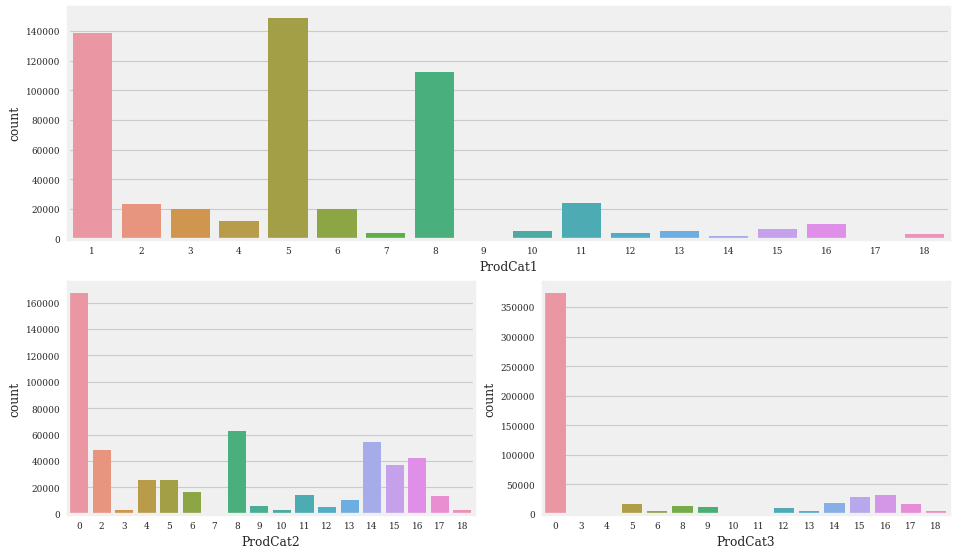

In [694]:
# Get the Product category distribution

style.use('seaborn-notebook') #sets the size of the charts
matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
fig = plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax1 = plt.subplot2grid((2,2),(1,0))
ax1 = sns.countplot(data.ProdCat2)
for label in ax1.xaxis.get_ticklabels():
    #label.set_rotation(45)
    label.set_fontsize(8)
for label in ax1.yaxis.get_ticklabels():
    label.set_fontsize(8)

ax2 = plt.subplot2grid((2,2),(1,1))
ax2 = sns.countplot(data.ProdCat3)
for label in ax2.xaxis.get_ticklabels():
    #label.set_rotation(45)
    label.set_fontsize(8)
for label in ax2.yaxis.get_ticklabels():
    label.set_fontsize(8)

ax3 = plt.subplot2grid((2,2),(0,0), colspan=2)
ax3 = sns.countplot(data.ProdCat1)
for label in ax3.xaxis.get_ticklabels():
    #label.set_rotation(45)
    label.set_fontsize(8)
for label in ax3.yaxis.get_ticklabels():
    label.set_fontsize(8)
plt.tight_layout()
#plt.subplots_adjust(left=0.9, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
#ax3.grid(True)



##### 2.2 Comments:
1. It can be seen that products 1,5 and 8 from Category 1 dominate the sales numbers by far and seem to be the favorites. 
2. There are a large number of products in Categories 2 and 3 that are either missing or not shopped for. Products in category 3 have very low numbers.
3. Although Category 2 is not all that popular, there are some products that seems to be popular. Such as 2,8,14 and 16. 

In [695]:
# Define a couple of functions to calculate the top_x and give a flattened view

def flatten(x):
    """ This function flattens the x-axis by inserting an underscore between its elements"""
    j=[]
    for multi_index in list(x):
        ele=[]
        if(str(type(multi_index))) =='<class \'tuple\'>':
            for i in list(multi_index):
                ele.append(str(i))
        else:
            ele.append(str(multi_index))
        j.append('_'.join(ele))
    return(j)

def top_x(df,sum_col,lst=[],top_n=5):
    """ Function returns the top n elements from a group by list, aggregated as sum by var(sum_col)"""
    y = df.groupby(lst)[sum_col].sum().to_frame().sort_values(by=sum_col, ascending=False)[:top_n]
    x = flatten(list(y.index))
    y = y.reset_index()
    y.index=x
    return y

# Example:
#y = top_x(data,'Purchase',['Gender','Occupation','Marital_Status','Age'],10)

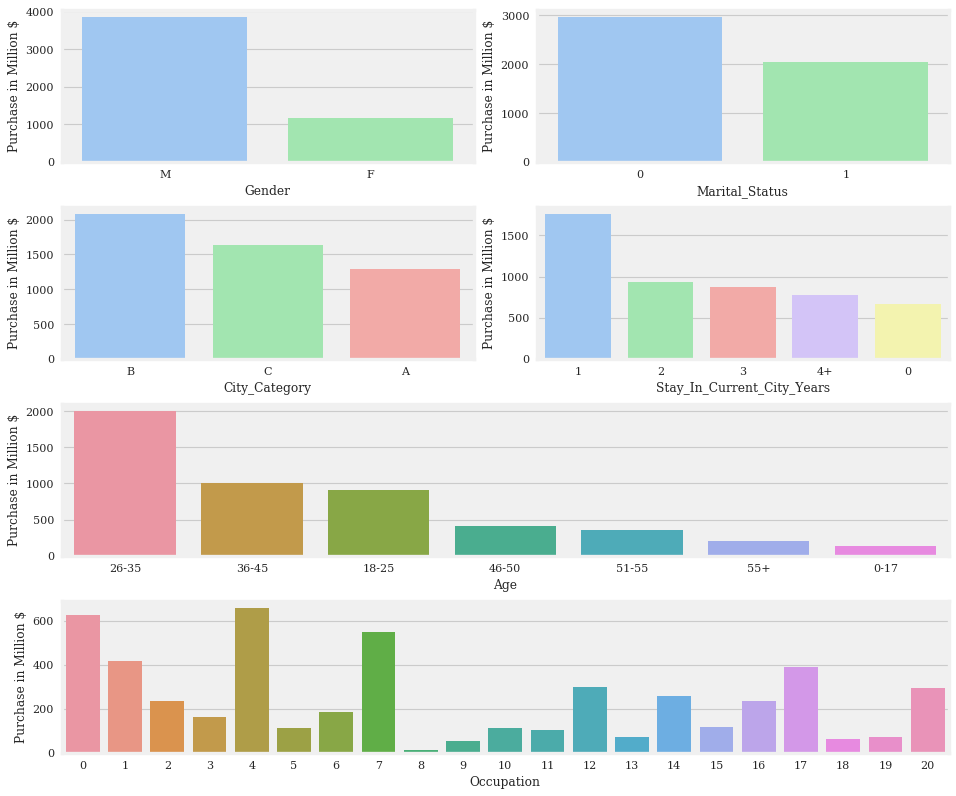

In [696]:
# Plot various histograms to see which one brings in the most money

matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
style.use('seaborn-notebook') #sets the size of the charts
style.use('seaborn-pastel') #set the style of the chart
fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot2grid((4,2),(0,0))
y = top_x(data,'Purchase',['Gender'],5)
ax1 = sns.barplot(y=y.Purchase/1000000, x='Gender', data=y, estimator=sum, ci=None)
ax1.set(ylabel='Purchase in Million $')

ax2 = plt.subplot2grid((4,2),(0,1))
y = top_x(data,'Purchase',['Marital_Status'],5)
ax2 = sns.barplot(y=y.Purchase/1000000, x='Marital_Status', data=y, estimator=sum, ci=None)
ax2.set(ylabel='Purchase in Million $')

ax3 = plt.subplot2grid((4,2),(1,0))
y = top_x(data,'Purchase',['City_Category'],5)
ax3 = sns.barplot(y=y.Purchase/1000000, x='City_Category', data=y, estimator=sum, ci=None)
ax3.set(ylabel='Purchase in Million $')

ax4 = plt.subplot2grid((4,2),(1,1))
y = top_x(data,'Purchase',['Stay_In_Current_City_Years'],5)
ax4 = sns.barplot(y=y.Purchase/1000000, x='Stay_In_Current_City_Years', data=y, estimator=sum, ci=None)
ax4.set(ylabel='Purchase in Million $')

ax5 = plt.subplot2grid((4,2),(2,0), colspan=20)
y = top_x(data,'Purchase',['Age'],10)
ax5 = sns.barplot(y=y.Purchase/1000000, x='Age', data=y, estimator=sum, ci=None)
ax5.set(ylabel='Purchase in Million $')

ax6 = plt.subplot2grid((4,2),(3,0), colspan=2)
y = top_x(data,'Purchase',['Occupation'],24)
ax6 = sns.barplot(y=y.Purchase/1000000, x='Occupation', data=y, estimator=sum, ci=None)
ax6.set(ylabel='Purchase in Million $')

plt.tight_layout()
plt.show()  

##### 2.3 Comments:
Comparing this to the counts plots, it is now clear that the distribution in amounts is quite similar to the distribution in counts. This means that no parameter disproportionately affects the amount. For example, it could have been possible that women bought all the expensive products and even though they shopped less number of times, they could have generated the most revenue. 
The two plots seems some what similar and we can conclude that no variable/distribution needs special attention.


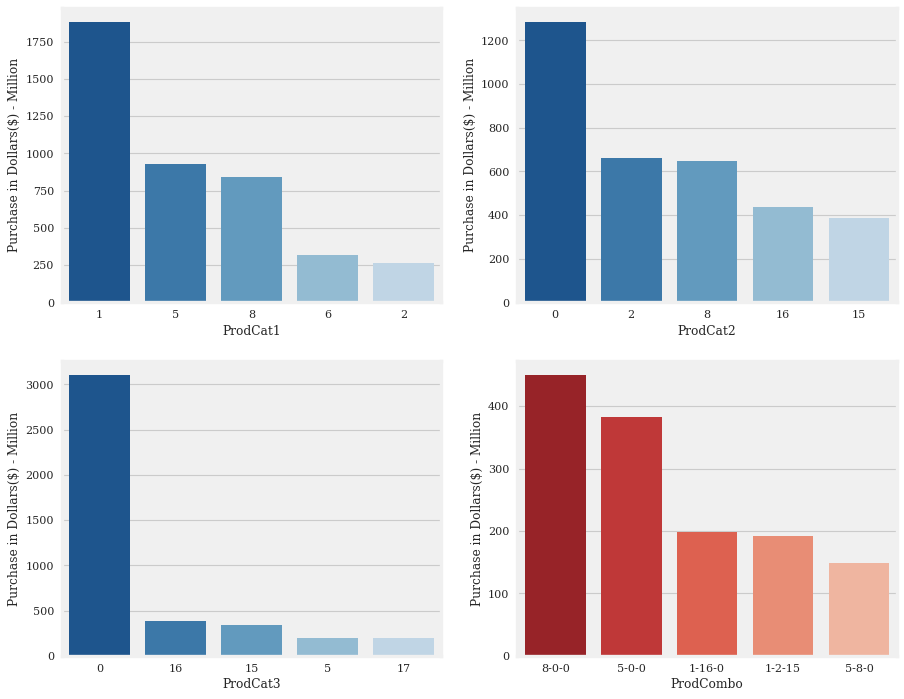

In [697]:
# Let us now have a look at which product Categories / combinations are top sellers

matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
style.use('seaborn-notebook') #sets the size of the charts
sns.set_palette("Blues_r")

#style.use('seaborn-pastel') #set the style of the chart
fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot2grid((2,2),(0,0))
y = top_x(data,'Purchase',['ProdCat1'],5)
ax1 = sns.barplot(y=y.Purchase/1000000, x='ProdCat1', data=y, estimator=sum, ci=None, order=y.ProdCat1)
sns.color_palette=("Blues_d")
ax1.set(ylabel='Purchase in Dollars($) - Million')

ax1 = plt.subplot2grid((2,2),(0,1))
y = top_x(data,'Purchase',['ProdCat2'],5)
ax1 = sns.barplot(y=y.Purchase/1000000, x='ProdCat2', data=y, estimator=sum, ci=None, order=y.ProdCat2)
ax1.set(ylabel='Purchase in Dollars($) - Million')

ax1 = plt.subplot2grid((2,2),(1,0))
y = top_x(data,'Purchase',['ProdCat3'],5)
ax1 = sns.barplot(y=y.Purchase/1000000, x='ProdCat3', data=y, estimator=sum, ci=None, order=y.ProdCat3)
ax1.set(ylabel='Purchase in Dollars($) - Million')

sns.set_palette("Reds_r")
ax1 = plt.subplot2grid((2,2),(1,1))
y = top_x(data,'Purchase',['ProdCombo'],5)
ax1 = sns.barplot(y=y.Purchase/1000000, x='ProdCombo', data=y, estimator=sum, ci=None, order=y.ProdCombo)
ax1.set(ylabel='Purchase in Dollars($) - Million')

plt.show()

##### 2.4 Comments:
By looking at the top revenue generators from products, it seems like it is a bit misleading when looking at isolated product categories. For example, it seems like product 1 is the most revenue generator overall from Category 1. And so are product 0 from Categories 2 and 3. However, the top revenue generator across the board is combination of product 8 from Category 1 and 0 from Categories 2 and 3 (i.e. 8-0-0). This also can be interpreted as product 1 from Category 1 is the top revenue generator, but it could be in combination with other products from Category 2 and 3. As you can see from the red graph that there are combinations of 1-16-0 and 1-2-15 in rank 3 & 4. There could be several other combinations which are not covered by the plots above. But product 8 from Category 1 is definitely the top revenue generator as Category 2 and 3 are 0 for it. 

In short, the ranking of ProdCombo columns needs to be looked at in conjunction with the ranking of individual ranking of product categories to derive any meaningful information from it. 

In [698]:
# Now lets start taking a deeper dive in to the data to figure out answers to questions such as:
# 1. What are the characteristics of my top revenue generators
# 2. Who buys the top product combinations

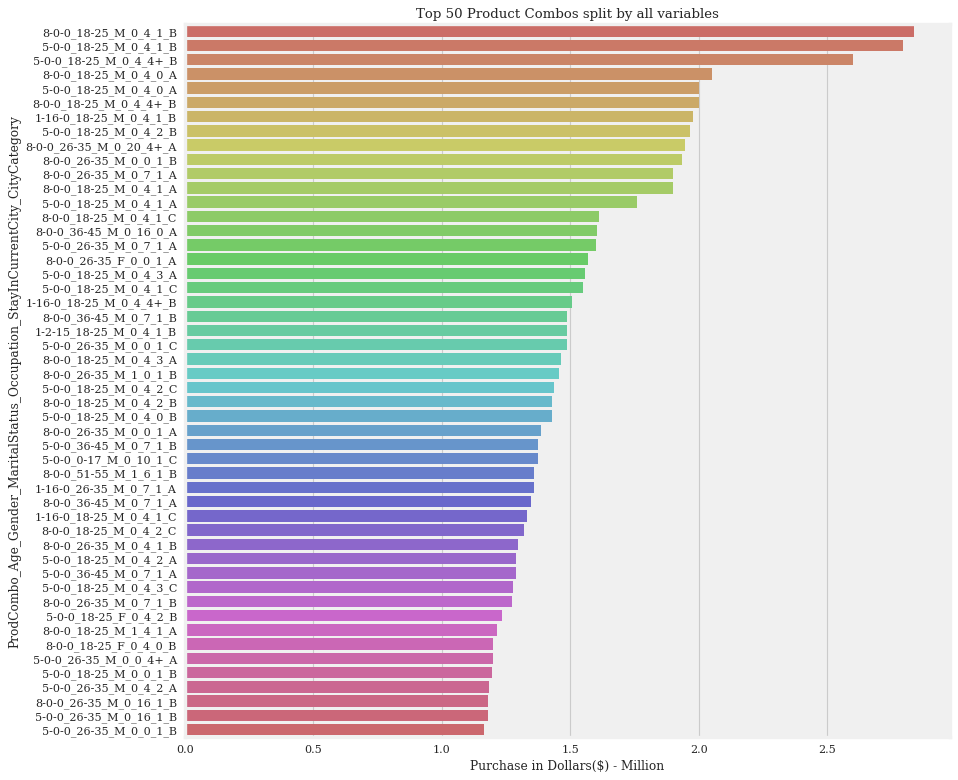

In [752]:
matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
style.use('seaborn-notebook') #sets the size of the charts
#style.use('seaborn-pastel')
sns.set_palette("hls",50)

#style.use('seaborn-pastel') #set the style of the chart
fig = plt.figure(num=None, figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')

ax1 = plt.subplot2grid((1,1),(0,0))
z = top_x(data,'Purchase',['ProdCombo','Age','Gender','Marital_Status','Occupation','Stay_In_Current_City_Years', 'City_Category'],50)
ax1 = sns.barplot(x=z.Purchase/1000000, y=z.index, data=z, estimator=sum, ci=None)
ax1.set(xlabel='Purchase in Dollars($) - Million')
ax1.set(ylabel='ProdCombo_Age_Gender_MaritalStatus_Occupation_StayInCurrentCity_CityCategory')
plt.title('Top 50 Product Combos split by all variables')

plt.show()

##### 2.5 Comments:
There is a lot to take in here. This plot is a master plot that shows all the Product combos that generate top revenue split by all parameters. But it is important to review the information here. It tell us a great deal, which we will need to process and aggregate this data to get meaningful insights. 

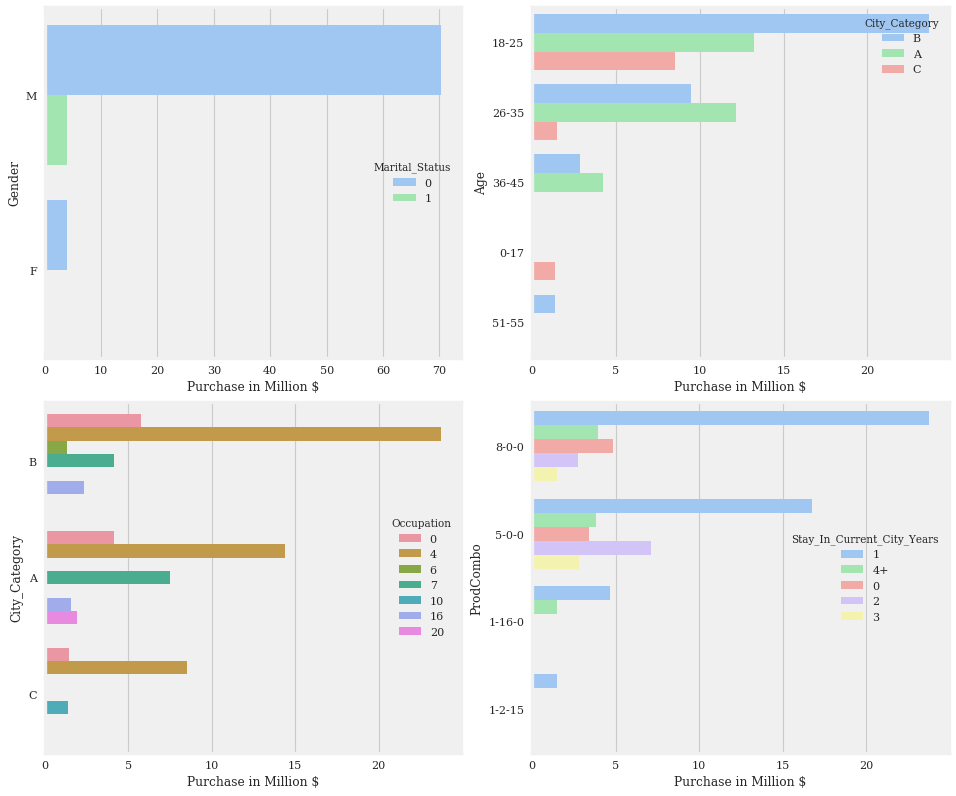

In [753]:
matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
style.use('seaborn-pastel')
#style.use('seaborn-pastel') #set the style of the chart
fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')


ax1 = plt.subplot2grid((2,2),(0,0))
ax1 = sns.barplot(x=z.Purchase/1000000, y=z['Gender'],  estimator=sum, hue=z['Marital_Status'], ci=None)
ax1.set(xlabel='Purchase in Million $')

ax2 = plt.subplot2grid((2,2),(0,1))
ax2 = sns.barplot(x=z.Purchase/1000000, y=z['Age'],  estimator=sum, hue=z['City_Category'], ci=None)
ax2.set(xlabel='Purchase in Million $')

ax3 = plt.subplot2grid((2,2),(1,0))
ax3 = sns.barplot(x=z.Purchase/1000000, y=z['City_Category'],  estimator=sum, hue=z['Occupation'], ci=None)
ax3.set(xlabel='Purchase in Million $')

ax4 = plt.subplot2grid((2,2),(1,1))
ax4 = sns.barplot(x=z.Purchase/1000000, y=z['ProdCombo'],  estimator=sum, hue=z['Stay_In_Current_City_Years'], ci=None)
ax4.set(xlabel='Purchase in Million $')

plt.tight_layout()
plt.show()

##### 2.6 Comments:
The above analysis answers the question: <b> Who is my valuable/target audience? </b>

These conclusions can be made from the above plots:<br>
1. Single males buy the most
2. These single males are mainly from city B, in age group of 18-35. They are followed by city A in age groups of 18-25 and 25-36.
3. A disproportionate number of these people are in Occupation 4, mainly buying from city B and A.
4. People who mainly buy ProdCombos 8-0-0 and 5-0-0 have been living in the city around 1 year. 

<b>Conclusion:</b>
The target/valuable audience for Black Friday sale are single males from cities A and B in the age group of 18-35 in occupation 4 who have been living in their cities for around 1 year.

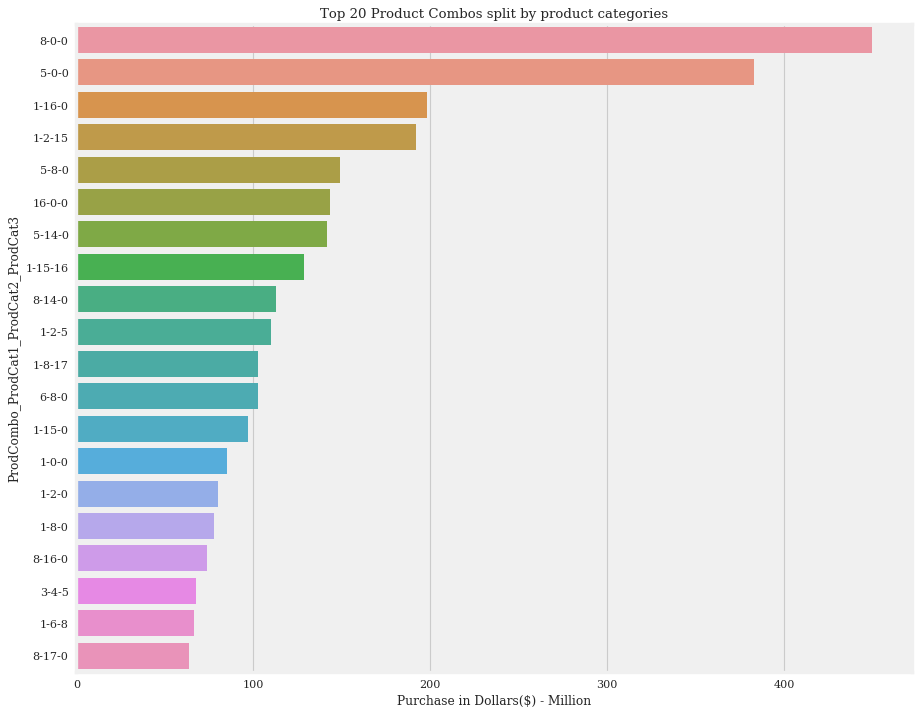

In [797]:
# Next we plot the top 20 combos so that we can analyze it in depth

matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
style.use('seaborn-pastel')
#style.use('seaborn-pastel') #set the style of the chart
fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

z = top_x(data,'Purchase',['ProdCombo','ProdCat1','ProdCat2','ProdCat3'],20)
z['ProdCat1'] = z.ProdCat1.astype(str)
z['ProdCat2'] = z.ProdCat2.astype(str)
z['ProdCat3'] = z.ProdCat3.astype(str)

ax1 = sns.barplot(x=z.Purchase/1000000, y=z.ProdCombo, data=z, estimator=sum, ci=None)
ax1.set(xlabel='Purchase in Dollars($) - Million')
ax1.set(ylabel='ProdCombo_ProdCat1_ProdCat2_ProdCat3')
plt.title('Top 20 Product Combos split by product categories')

plt.show()

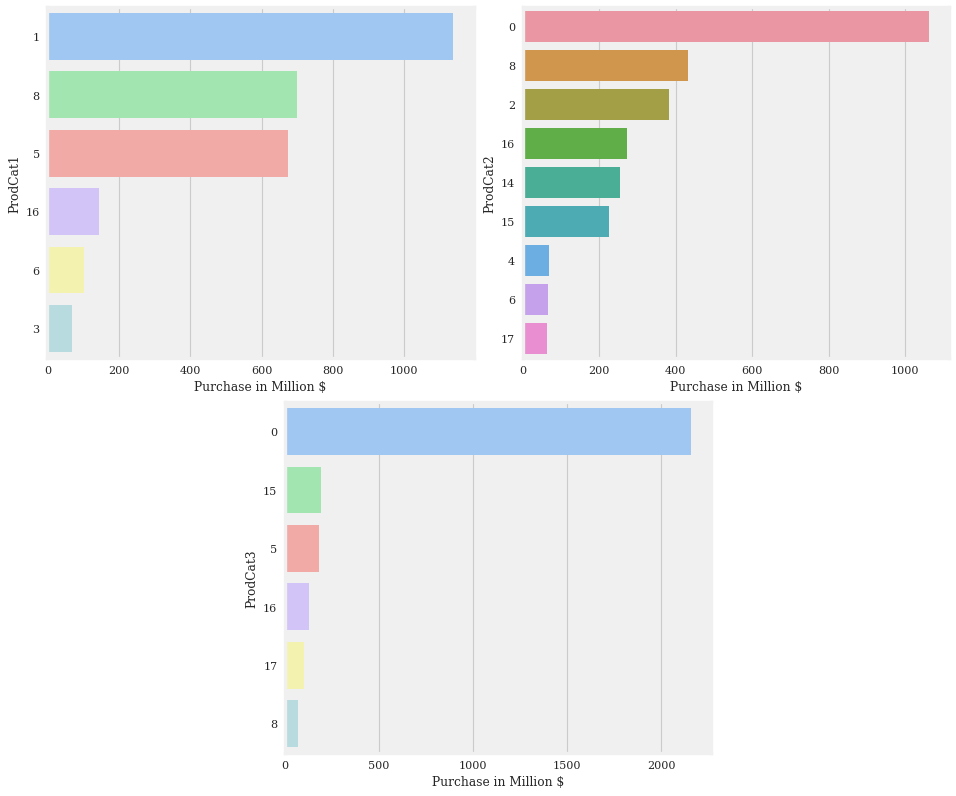

In [796]:
# Now we can compare which products from the top 20 combo get the most revenue.

matplotlib.rcParams.update({'font.size': 8}) #set font for chart labels
style.use('seaborn-pastel')
fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')


ax1 = plt.subplot2grid((2,4),(0,0), colspan=2)
ax1 = sns.barplot(x=z.Purchase/1000000, y=z['ProdCat1'], estimator=sum, orient='h', ci=None
                  , order=np.array(z.groupby('ProdCat1')['Purchase'].sum().sort_values(ascending=False).index))
ax1.set(xlabel='Purchase in Million $')


ax2 = plt.subplot2grid((2,4),(0,2), colspan=2)
ax2 = sns.barplot(x=z.Purchase/1000000, y=z['ProdCat2'], estimator=sum, orient='h', ci=None
                  , order=np.array(z.groupby('ProdCat2')['Purchase'].sum().sort_values(ascending=False).index))
ax2.set(xlabel='Purchase in Million $')

ax3 = plt.subplot2grid((2,4),(1,1), colspan=2)
ax3 = sns.barplot(x=z.Purchase/1000000, y=z['ProdCat3'], estimator=sum, orient='h', ci=None
                  , order=np.array(z.groupby('ProdCat3')['Purchase'].sum().sort_values(ascending=False).index))
ax3.set(xlabel='Purchase in Million $')

plt.tight_layout()
plt.show()

##### 2.7 Comments:
The above analysis attempts to answer this question: <b> Which are my top product categories and combos?</b>

In the top 20 combos, you can now confirm that product 1 in Category 1 still has the most number of combos and generates the highest revenue, followed by 8 and 5. In terms of combos across all three categories, 1-2-15, 1-15-16 and 1-2-5 are frequently bought together. Overall, assuming that these 3 categories hav independent products, the top products are:<br>
Category 1: 1,8,5<br>
Category 2: 8,2,16<br>
Category 3: 15,5,16<br>

### Step 3 - EDA - Search for correlations, significant variables and hypothesis testing

In [799]:
data

,User_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,ProdCat1,ProdCat2,ProdCat3,ProdCombo
0,1000001,F,0-17,10,A,2,0,8370,3,0,0,3-0-0
1,1000001,F,0-17,10,A,2,0,15200,1,6,14,1-6-14
2,1000001,F,0-17,10,A,2,0,1422,12,0,0,12-0-0
3,1000001,F,0-17,10,A,2,0,1057,12,14,0,12-14-0
4,1000002,M,55+,16,C,4+,0,7969,8,0,0,8-0-0
5,1000003,M,26-35,15,A,3,0,15227,1,2,0,1-2-0
6,1000004,M,46-50,7,B,2,1,19215,1,8,17,1-8-17
7,1000004,M,46-50,7,B,2,1,15854,1,15,0,1-15-0
8,1000004,M,46-50,7,B,2,1,15686,1,16,0,1-16-0
9,1000005,M,26-35,20,A,1,1,7871,8,0,0,8-0-0
